# Observed NDVI data along trajectories of moisture flux

- Data from ERA-INTERIM and from GIMMS.
- Specific humidity and moisture flux.
- Single and multiple trajectories using `cdlearn.trajectories.StaticTrajectory` class.
- Get observed NDVI data along a single trajectory.

## 1 Initial setup

In [1]:
%load_ext autoreload
%autoreload 2  

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load packages.
import sys
import glob
import calendar

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats
from dask.diagnostics import ProgressBar

%matplotlib inline

In [4]:
print(">>> Version of xarray:", xr.__version__)
print(">>> Version of pandas:", pd.__version__)

>>> Version of xarray: 0.14.0
>>> Version of pandas: 0.25.0


In [5]:
# My repository.
repository = "/home/alex/Dropbox/repositories/"

# Include once my repository in the path for searching libraries.
if repository not in sys.path:
    sys.path.append(repository)
    
# Import my package.
import cdlearn

# Map borders.
loni, lonf, lati, latf = -90, -30, -60, 20

# Time range. 
ti, tf = "1981-07", "2012-09"

# Where figures will be put.
fig_path = "/home/alex/Dropbox/repositories/phd/images/"

In [6]:
# Main folder with data.
DATA_FOLDER = "/media/alex/ALEXDATA/data_sets/"

# Moisture transport data folder.
MOISTURE_FOLDER = DATA_FOLDER + "ERA_INTERIM/moisture_transport_mmeans/"

# NDVI data folder.
VEGETATION_FOLDER = DATA_FOLDER + "/GIMMS/NDVI_mmeans/"

## 2 Load and preprocess data

### 2.1 Moisture transport

In [7]:
# List files.
MOISTURE_FILES = sorted(glob.glob(MOISTURE_FOLDER + "*.grb"))

**Command for deleting index files:**

```bash
$ find /media/alex/ALEXDATA/data_sets/ERA_INTERIM/ -name "*.idx" -type f -delete
```

In [8]:
%%time

# DataSets objects.
DS_mt = xr.open_mfdataset(MOISTURE_FILES, engine="cfgrib", concat_dim="time")
DS_mt

CPU times: user 1min 12s, sys: 794 ms, total: 1min 13s
Wall time: 1min 14s


<xarray.Dataset>
Dimensions:           (latitude: 241, longitude: 480, time: 405)
Coordinates:
    entireAtmosphere  int64 0
    step              timedelta64[ns] 00:00:00
  * latitude          (latitude) float64 -90.0 -89.25 -88.5 ... 88.5 89.25 90.0
  * longitude         (longitude) float64 0.0 0.75 1.5 ... 357.8 358.5 359.2
  * time              (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2012-09-01
    valid_time        (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2012-09-01
Data variables:
    v                 (time, latitude, longitude) float32 dask.array<chunksize=(1, 241, 480), meta=np.ndarray>
    q                 (time, latitude, longitude) float32 dask.array<chunksize=(1, 241, 480), meta=np.ndarray>
    sp                (time, latitude, longitude) float32 dask.array<chunksize=(1, 241, 480), meta=np.ndarray>
    stl1              (time, latitude, longitude) float32 dask.array<chunksize=(1, 241, 480), meta=np.ndarray>
    swl1              (time, latitude, longitude)

In [9]:
%%time

# Shift longitudes and guarantee time ordering.
DS_mt = DS_mt.assign_coords(longitude=(DS_mt.longitude + 180) % 360 - 180)
DS_mt = DS_mt.sortby(DS_mt.latitude)
DS_mt = DS_mt.sortby(DS_mt.longitude)
DS_mt = DS_mt.sortby(DS_mt.time)
DS_mt

CPU times: user 107 ms, sys: 3.96 ms, total: 111 ms
Wall time: 116 ms


<xarray.Dataset>
Dimensions:           (latitude: 241, longitude: 480, time: 405)
Coordinates:
    entireAtmosphere  int64 0
    step              timedelta64[ns] 00:00:00
  * latitude          (latitude) float64 -90.0 -89.25 -88.5 ... 88.5 89.25 90.0
  * longitude         (longitude) float64 -180.0 -179.2 -178.5 ... 178.5 179.2
  * time              (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2012-09-01
    valid_time        (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2012-09-01
Data variables:
    v                 (time, latitude, longitude) float32 dask.array<chunksize=(1, 241, 480), meta=np.ndarray>
    q                 (time, latitude, longitude) float32 dask.array<chunksize=(1, 241, 480), meta=np.ndarray>
    sp                (time, latitude, longitude) float32 dask.array<chunksize=(1, 241, 480), meta=np.ndarray>
    stl1              (time, latitude, longitude) float32 dask.array<chunksize=(1, 241, 480), meta=np.ndarray>
    swl1              (time, latitude, longitud

In [10]:
# South America at commom time range.
DS_mt = DS_mt.sel(
    longitude=slice(loni, lonf), latitude=slice(lati, latf), time=slice(ti, tf)
)
DS_mt

<xarray.Dataset>
Dimensions:           (latitude: 107, longitude: 81, time: 375)
Coordinates:
    entireAtmosphere  int64 0
    step              timedelta64[ns] 00:00:00
  * latitude          (latitude) float64 -60.0 -59.25 -58.5 ... 18.0 18.75 19.5
  * longitude         (longitude) float64 -90.0 -89.25 -88.5 ... -30.75 -30.0
  * time              (time) datetime64[ns] 1981-07-01 1981-08-01 ... 2012-09-01
    valid_time        (time) datetime64[ns] 1981-07-01 1981-08-01 ... 2012-09-01
Data variables:
    v                 (time, latitude, longitude) float32 dask.array<chunksize=(1, 107, 81), meta=np.ndarray>
    q                 (time, latitude, longitude) float32 dask.array<chunksize=(1, 107, 81), meta=np.ndarray>
    sp                (time, latitude, longitude) float32 dask.array<chunksize=(1, 107, 81), meta=np.ndarray>
    stl1              (time, latitude, longitude) float32 dask.array<chunksize=(1, 107, 81), meta=np.ndarray>
    swl1              (time, latitude, longitude) flo

In [11]:
# Let's correct the names and meanings of variables according to control file and the 
# introduction of this notebook.
FP = MOISTURE_FOLDER + "mmeans_qv.ctl"
!head $FP -n 100

dset ^mmeans_qv_%y4_%m2.grb
title File
options template
undef 1e+20
dtype grib
index ^mmeans_qv.gmp
xdef 480 linear 0.000000 0.750000
ydef 241 linear -90.000000 0.750000
zdef 1 levels 1013
tdef 405 linear 0Z1jan1979  1mon
vars 5
qt        0  132,200,  0,  0 vint specific humidity [kg/m2]
ut        0  133,200,  0,  0 vint zonal wind [kg/m/s]
vt        0  134,200,  0,  0 vint meridional wind [kg/m/s]
qu        0  139,200,  0,  0 vint zonal moisture flux [kg/m/s]
qv        0  140,200,  0,  0 vint meridional moisture flux [kg/m/s]
endvars


In [12]:
%%time

# Let's rename some variables.
DS_mt = DS_mt.rename(
    name_dict={"v": "w", 
               "q": "Uwind",     
               "sp": "Vwind", 
               "stl1": "Fx", 
               "swl1": "Fy"}
)

# Names and units for variables.
long_names = [
    "specific humidity [kg/m2]", 
    "zonal wind [kg/m/s]",
    "meridional wind [kg/m/s]",
    "zonal moisture flux [kg/m/s]",
    "meridional moisture flux [kg/m/s]"
]

# Put them as attributes.
for var_name, long_name in zip(DS_mt.data_vars.keys(), long_names):
    DS_mt[var_name].attrs = {}
    DS_mt[var_name].attrs["long_name"] = long_name

CPU times: user 1.93 ms, sys: 0 ns, total: 1.93 ms
Wall time: 1.87 ms


In [13]:
DS_mt

<xarray.Dataset>
Dimensions:           (latitude: 107, longitude: 81, time: 375)
Coordinates:
    entireAtmosphere  int64 0
    step              timedelta64[ns] 00:00:00
  * latitude          (latitude) float64 -60.0 -59.25 -58.5 ... 18.0 18.75 19.5
  * longitude         (longitude) float64 -90.0 -89.25 -88.5 ... -30.75 -30.0
  * time              (time) datetime64[ns] 1981-07-01 1981-08-01 ... 2012-09-01
    valid_time        (time) datetime64[ns] 1981-07-01 1981-08-01 ... 2012-09-01
Data variables:
    w                 (time, latitude, longitude) float32 dask.array<chunksize=(1, 107, 81), meta=np.ndarray>
    Uwind             (time, latitude, longitude) float32 dask.array<chunksize=(1, 107, 81), meta=np.ndarray>
    Vwind             (time, latitude, longitude) float32 dask.array<chunksize=(1, 107, 81), meta=np.ndarray>
    Fx                (time, latitude, longitude) float32 dask.array<chunksize=(1, 107, 81), meta=np.ndarray>
    Fy                (time, latitude, longitude) flo

**I have some doubts about units.**

In [14]:
# Calculate velocities of air masses.
DS_mt = DS_mt.assign(u = DS_mt.Fx / DS_mt.w, v = DS_mt.Fy / DS_mt.w)

In [15]:
# Load into memory.
with ProgressBar():
    DS_mt = DS_mt.compute()

[########################################] | 100% Completed | 25.0s


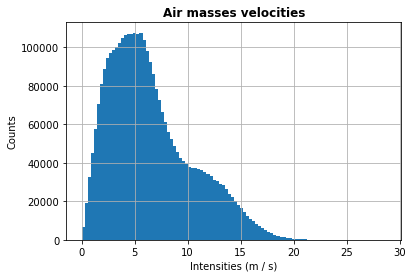

In [16]:
# Air masses intensities.
factor = 1 # (m / s).
vel = np.sqrt((DS_mt.u * factor) **2 + (DS_mt.v * factor) ** 2)
plt.hist(vel.values.flatten(), bins=100);
plt.title("Air masses velocities", weight="bold")
plt.xlabel("Intensities (m / s)")
plt.ylabel("Counts")
plt.grid();

### 2.2 NDVI

In [17]:
# List files.
VEGETATION_FILES = sorted(glob.glob(VEGETATION_FOLDER + "*.nc4"))

In [18]:
%%time

# Lazy read of global data sets.
DS_ndvi = xr.open_mfdataset(VEGETATION_FILES, concat_dim="time")

# Latitude in ascending order.
DS_ndvi = DS_ndvi.sortby(DS_ndvi.latitude)

CPU times: user 313 ms, sys: 7.71 ms, total: 321 ms
Wall time: 324 ms


In [19]:
# South America at commom time range.
DS_ndvi = DS_ndvi.sel(
    longitude=slice(loni, lonf), latitude=slice(lati, latf), time=slice(ti, tf)
)
DS_ndvi

<xarray.Dataset>
Dimensions:    (latitude: 107, longitude: 81, time: 375)
Coordinates:
  * latitude   (latitude) float64 -60.0 -59.25 -58.5 -57.75 ... 18.0 18.75 19.5
  * longitude  (longitude) float64 -90.0 -89.25 -88.5 ... -31.5 -30.75 -30.0
  * time       (time) datetime64[ns] 1981-07-01 1981-08-01 ... 2012-09-01
Data variables:
    ndvi       (time, latitude, longitude) float64 dask.array<chunksize=(6, 107, 81), meta=np.ndarray>

In [20]:
# Load into memory.
with ProgressBar():
    DS_ndvi = DS_ndvi.compute()

[########################################] | 100% Completed |  0.5s


In [21]:
# Put mask.
DS_ndvi = cdlearn.pixels.EraInterimGrid.add_land_mask(DS_ndvi)

## 3 Trajectories

### 3.1 Testing a single trajectory using `cdlearn.trajectories.StaticTrajectory`.

In [22]:
from importlib import reload

In [23]:
reload(cdlearn.trajectories);

In [24]:
# Select an initial time step.
time0 = "2012-01-01"

# Initial position.
p0 = np.array([0, -35])

# Scalar and vectorial data.
U=DS_mt.u.sel(time=time0, method="nearest")
V=DS_mt.v.sel(time=time0, method="nearest")

# Initialize trajectory.
st = cdlearn.trajectories.StaticTrajectory(U=U, V=V, angular_position0=p0, time0=time0)

# Run trajectory.
df_trajectory = st.run(dt=2500, T=30*24*60*60, verbose=True)

>>> Trajectory running free ...


 97% (1010 of 1036) |################### | Elapsed Time: 0:00:03 ETA:   0:00:00

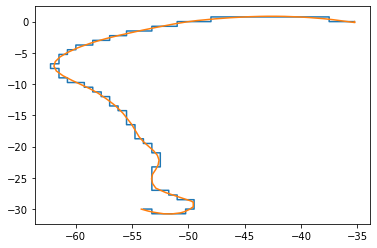

In [25]:
plt.plot(df_trajectory.lon_grid, df_trajectory.lat_grid)
plt.plot(df_trajectory.longitude, df_trajectory.latitude)

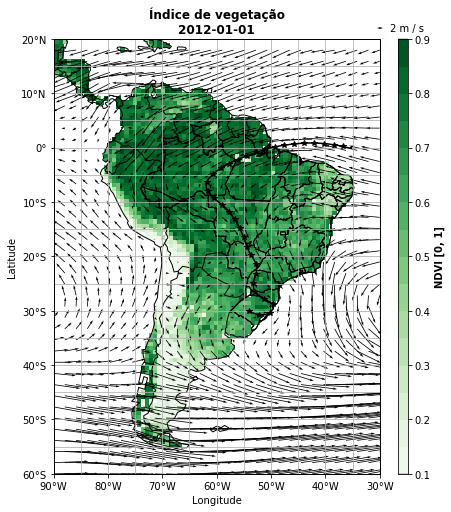

In [26]:
# Plot moisture transport with NDVI.
plotmap, axgr = cdlearn.maps.vectorial_single_plot(
    data_array=DS_ndvi.ndvi.sel(time=time0).where(DS_ndvi.land_mask==True),
    U=DS_mt.u.sel(time=time0),
    V=DS_mt.v.sel(time=time0),
    vmin=0.1,
    vmax=0.9,
    levels=np.arange(0.10, 0.95, 0.05),
    cmap=plt.cm.Greens,
    title="Índice de vegetação\n" + time0,
    clabel="NDVI [0, 1]",
    cticks=np.arange(0.1, 1.0, 0.1),
    vunits="m / s",
    figsize=(8, 8)
)

# Plot trajectory.
axgr = cdlearn.maps.draw_trajectory(
    df_trajectory=df_trajectory,
    axgr=axgr,
    color="black",
    show_stars=True,
    d_stars=200e3
)

In [27]:
# NDVI data along trajectory.
df_trajectory_with_data = st.add_data_along_trajectory(
    df_trajectory=df_trajectory,
    data_array=DS_ndvi.ndvi.sel(time=time0).where(DS_ndvi.land_mask==True),
    var_name="ndvi",
    verbose=True
)

>>> Get data along trajectoy's path...


 96% (998 of 1037) |#################### | Elapsed Time: 0:00:01 ETA:   0:00:00

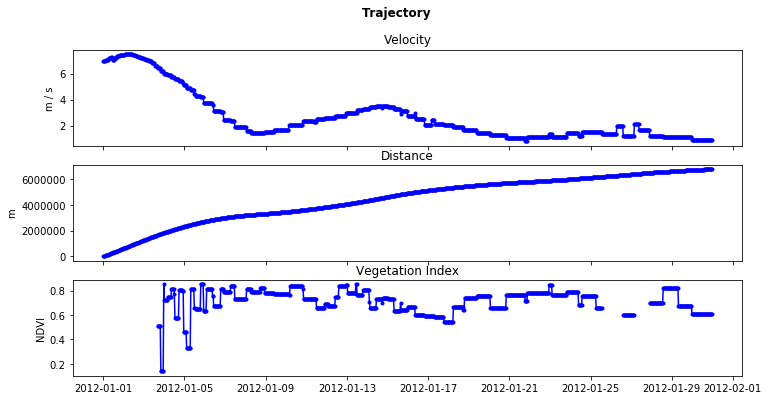

In [28]:
# Some plots for this trajectory.
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(12, 6))
vel = np.sqrt(df_trajectory_with_data.uwind ** 2 + df_trajectory_with_data.vwind ** 2)

# Velocity.              
axes[0].plot(vel.index, vel.values, ".-b")
axes[0].set_title("Velocity")
axes[0].set_ylabel("m / s")

# Distance.              
axes[1].plot(df_trajectory_with_data.index, df_trajectory_with_data.distance, ".-b")
axes[1].set_title("Distance")
axes[1].set_ylabel("m")

# Data.  
axes[2].plot(df_trajectory_with_data.index, df_trajectory_with_data.ndvi, ".-b")
axes[2].set_title("Vegetation Index")
axes[2].set_ylabel("NDVI")

plt.suptitle("Trajectory", weight="bold");

### 3.2 Ensemble of trajectories using `cdlearn.trajectories.StaticTrajectory`.

In [29]:
%%time

# Initial position.
p0 = np.array([0, -35]) # This is very good initial position! Keep it!

# Time integration parameters.
dt = 2500        # Time step.
T = 25*24*60*60  # 25 days.

# Time index. Sanity check.
DS_ti, _ = xr.align(DS_ndvi.time, DS_mt.time)

# Months and years.
months = np.unique(DS_ti.dt.month)
months = np.arange(1, 13).tolist()

# Put all trajectories here.
trajectories_dict = {}

# Sazonal loop.
for month in months:

    month_str = calendar.month_name[month]    
    print(">>> Processing", month_str, "...")
    
    # The same month across years.
    time_mask = DS_ti.time.dt.month == month
    time0s = pd.to_datetime(
        DS_ndvi.time.sel(time=DS_ndvi.time[time_mask]).values
    )
    
    # Loop over years at the same month.
    for time0 in time0s:
        
        # Scalar and vectorial data.
        U=DS_mt.u.sel(time=time0, method="nearest")
        V=DS_mt.v.sel(time=time0, method="nearest")
        
        # Initialize trajectory.
        st = cdlearn.trajectories.StaticTrajectory(
            U=U, 
            V=V, 
            angular_position0=p0, 
            time0=time0
        )

        # Run trajectory.
        df_trajectory = st.run(dt=dt, T=T)
        
        # Save trajectories.
        year_str = str(time0.year)
        key = year_str + str("-%02d" %month)
        trajectories_dict[key] = df_trajectory

>>> Processing January ...
>>> Processing February ...
>>> Processing March ...
>>> Processing April ...
>>> Processing May ...
>>> Processing June ...
>>> Processing July ...
>>> Processing August ...
>>> Processing September ...
>>> Processing October ...
>>> Processing November ...
>>> Processing December ...
CPU times: user 17min 41s, sys: 1.99 s, total: 17min 43s
Wall time: 17min 51s


CPU times: user 19.9 s, sys: 1.29 s, total: 21.2 s
Wall time: 19.1 s


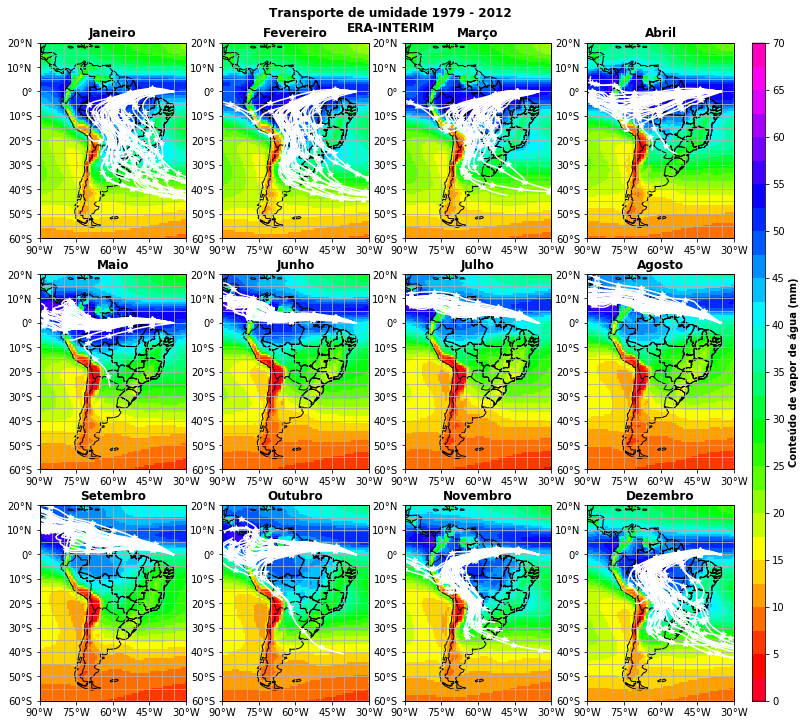

In [30]:
%%time

# Skeleton for South America maps.
axgr = cdlearn.maps.south_america_months()

# Monthly means for specific humidity.
DA_w_mm = DS_mt.w.groupby("time.month").mean("time")

# Dispersion of trajectories for each month.
for index, axis in enumerate(axgr):
        
    # Plot data on these maps.
    p = DA_w_mm[index].plot(
        ax=axis,
        vmin=0,
        vmax=75,
        levels=np.arange(0, 70.0 + 2.5, 2.5),
        cmap=plt.cm.gist_rainbow,
        add_colorbar=False,
        add_labels=False
    )    
    
    axis.set_title(cdlearn.auxiliary.months_labels_pt[index], weight="bold")
    
    # Month string (01, 02, ..., 12).    
    month_str = str("%02d" %(index + 1))    
    
    # Same month in all years.
    date = "-" + month_str
    for key in trajectories_dict.keys():
        if date in key:
    
            # Plot trajectories.
            axgr = cdlearn.maps.draw_trajectory(
                df_trajectory=trajectories_dict[key],
                axgr=axgr,
                axgr_index=index,    
                color="white",
                show_stars=True
            )

# Fill common colorbar.        
cb = axgr.cbar_axes[0].colorbar(p)
cb.set_label_text("Conteúdo de vapor de água (mm)", weight="bold")
cb.cbar_axis.set_ticks(np.arange(0, 70 + 5, 5)) 
plt.suptitle("Transporte de umidade 1979 - 2012\nERA-INTERIM", weight="bold")
plt.subplots_adjust(top=0.99) 

# Save figures.
plt.savefig(fig_path + "specific_humidity_and_moisture_flux_erainterim_mmeans_tra_disp_pt.jpg", 
            dpi=200, bbox_inches="tight")            